In [125]:
import optuna
import joblib
import numpy as np
import pandas as pd
import sys
import joblib
import matplotlib.pyplot as plt
from tdc.single_pred import ADME
from concurrent.futures import ThreadPoolExecutor
from optuna.storages import JournalStorage, JournalFileStorage
from optuna.visualization import plot_param_importances
import plotly.subplots as sp
import plotly.graph_objs as go
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from jazzy.api import molecular_vector_from_smiles as mol_vect
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import fp_from_smiles, HyperparamTuner, tanimoto, create_interactive_scatter_plot, parse_jazzy_df

In [126]:
model_identifiers = ["linear", "KRR", "GB", "RF", "ANN"]
tdc_benchmarks = ["obach", "microsome", "hepatocyte"]
feature_types = ["morgan", "jazzy"]

# sampler - a method used to generate new sets of hyperparameters in each iteration of the optimization process
samplers = {
    'RandomSampler': optuna.samplers.RandomSampler,          # Sampler that selects hyperparameters randomly from the search space.
    'GridSampler': optuna.samplers.GridSampler,              # Sampler that performs a grid search over the hyperparameter space.
    'TPESampler': optuna.samplers.TPESampler,                # Sampler that uses a tree-structured Parzen estimator to model the objective function and sample new points from the search space.
    'CmaEsSampler': optuna.samplers.CmaEsSampler,            # Sampler that uses the Covariance Matrix Adaptation Evolution Strategy algorithm to efficiently search the hyperparameter space.
    'NSGAIISampler': optuna.samplers.NSGAIISampler,          # Multi-objective evolutionary algorithm that generates new samples using non-dominated sorting and crowding distance selection.
    'QMCSampler': optuna.samplers.QMCSampler,                # Quasi-Monte Carlo sampler that uses low-discrepancy sequences to sample the search space in a more efficient and evenly distributed way than random sampling.
    'BoTorchSampler': optuna.integration.BoTorchSampler,     # Sampler that leverages the BoTorch library for Bayesian optimization and can handle both continuous and categorical hyperparameters.
    'BruteForceSampler': optuna.samplers.BruteForceSampler,  # Sampler that exhaustively evaluates all possible combinations of hyperparameters in the search space.
}
# pruner - a technique used to eliminate unpromising trials during the course of hyperparameter optimization.
pruners = {
    'BasePruner': optuna.pruners.BasePruner,                            # This is the base class for all pruning strategies in Optuna. It provides a skeleton for implementing custom pruning strategies.
    'MedianPruner': optuna.pruners.MedianPruner,                        # A pruner that prunes unpromising trials that have median objective values, as determined in previous steps.
    'SuccessiveHalvingPruner': optuna.pruners.SuccessiveHalvingPruner,  # This pruner repeatedly splits trials into halves, discarding the lower performing half at each iteration.
    'HyperbandPruner': optuna.pruners.HyperbandPruner,                  # This pruner implements the Hyperband algorithm, which selects promising trials and runs them with different resource allocation schemes to determine the best one.
    'PercentilePruner': optuna.pruners.PercentilePruner,                # A pruner that prunes unpromising trials based on their percentile rank relative to all completed trials.
    'NopPruner': optuna.pruners.NopPruner,                              # A pruner that does nothing and does not prune any trials.
    'ThresholdPruner': optuna.pruners.ThresholdPruner,                  # This pruner prunes trials that have not reached a certain level of performance (i.e., objective value).
    'PatientPruner': optuna.pruners.PatientPruner,                      # This pruner prunes trials that do not show improvement over a certain number of steps (or epochs).
}

halflives = {}
tdc_datasets = {}
rmsds = {}
ranks = {}
y_predicted = {}
best_trials = {}
best_models = {}
best_model_hyperparams = {}

In [127]:
obach = ADME(name='Half_Life_Obach')
obach_split = obach.get_split()
tdc_datasets["obach"] = obach_split
microsome = ADME(name='Clearance_Microsome_AZ')
microsome_split = microsome.get_split()
tdc_datasets["microsome"] = microsome_split
hepatocyte = ADME(name='Clearance_Hepatocyte_AZ')
hepatocyte_split = hepatocyte.get_split()
tdc_datasets["hepatocyte"] = hepatocyte_split

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [128]:
halflives["morgan"] = {}
for benchmark in tdc_benchmarks:
    print(benchmark)
    halflives["morgan"][benchmark] = {}
    
    benchmark_train_halflives = tdc_datasets[benchmark]["train"]["Y"]
    benchmark_test_halflives = tdc_datasets[benchmark]["test"]["Y"]
    
    reshaped_train_halflife = np.array(benchmark_train_halflives).reshape(-1, 1)
    scaler = MinMaxScaler().fit(reshaped_train_halflife)
    train_halflife_scaled = scaler.transform(reshaped_train_halflife)
    train_halflives_scaled = np.array([val[0] for val in train_halflife_scaled])

    reshaped_test_halflife = np.array(benchmark_test_halflives).reshape(-1, 1)
    scaler = MinMaxScaler().fit(reshaped_test_halflife)
    test_halflife_scaled = scaler.transform(reshaped_test_halflife)
    test_halflives_scaled = np.array([val[0] for val in test_halflife_scaled])
    
    halflives["morgan"][benchmark]["train"] = np.array(train_halflives_scaled)
    halflives["morgan"][benchmark]["test"] = np.array(test_halflives_scaled)
    
    print(halflives["morgan"].keys())
    
    print(benchmark_train_halflives.shape, benchmark_test_halflives.shape)

obach
dict_keys(['obach'])
(467,) (133,)
microsome
dict_keys(['obach', 'microsome'])
(772,) (220,)
hepatocyte
dict_keys(['obach', 'microsome', 'hepatocyte'])
(849,) (243,)


In [129]:
halflives["jazzy"] = {}
for benchmark in tdc_benchmarks:
    print(benchmark)
    train_jazzy_df = pd.read_csv(f"project_resources/jazzy_splits/{benchmark}_train.csv")
    test_jazzy_df = pd.read_csv(f"project_resources/jazzy_splits/{benchmark}_test.csv")
    train_fts, train_jazzy_thalfs, contains_nan = parse_jazzy_df(train_jazzy_df, no_idx_smi=True)
    test_fts, test_jazzy_thalfs, contains_nan = parse_jazzy_df(test_jazzy_df, no_idx_smi=True)
    
    halflives["jazzy"][benchmark] = {}
    halflives["jazzy"][benchmark]["train"] = train_jazzy_thalfs
    halflives["jazzy"][benchmark]["test"] = test_jazzy_thalfs
    
    print(np.array(train_jazzy_thalfs).shape, np.array(test_jazzy_thalfs).shape)

obach
     525, [0.0033169983665033, 11.3305, 0.0, 3.3351, -4.054, -69.5826, -60.2942]
     130, [0.0078064793190067, 10.9705, 1.8136, 5.8249, -16.4281, -118.9807, -121.6516]
(525,) (130,)
microsome
     882, [0.0652380952380952, 10.5072, 1.4478, 4.6964, -13.5025, -92.8889, -106.3914]
     220, [0.0884353741496598, 3.5084, 3.5128, 4.5042, -12.6756, -80.3865, -84.2257]
(882,) (220,)
hepatocyte
     970, [0.0, 9.8552, 1.4451, 4.4407, -15.1209, -91.0733, -102.926]
     243, [0.0825850340136054, 10.2098, 1.292, 5.2199, -18.4498, -95.9609, -98.199]
(970,) (243,)


In [130]:
# load all models from optuna
# and get the hyperparameters of the best model from each study
# doesn't get the user_attrs={'fit_intercept': True} from linear, need to get manually
for _type in feature_types:
    best_trials[_type] = {}
    rmsds[_type] = {}
    best_model_hyperparams[_type] = {}
    for benchmark in tdc_benchmarks:
        best_trials[_type][benchmark] = {}
        rmsds[_type][benchmark] = {}
        best_model_hyperparams[_type][benchmark] = {}
        for model_id in model_identifiers:
            jl = joblib.load(f"project_resources/optuna/{benchmark}/{_type}/{model_id}.pkl")
            best_trials[_type][benchmark][model_id] = jl.best_trial.number
            rmsds[_type][benchmark][model_id] = jl.best_trial.values[0]
            best_model_hyperparams[_type][benchmark][model_id] = jl.best_trial.params
print(rmsds["morgan"]["obach"]["linear"])
print(best_model_hyperparams["morgan"]["obach"]["linear"])

0.05899404509715097
{'alpha': 0.07523591141058908, 'l1_ratio': 0.1053690484640323}


In [131]:
plots = []
titles = []
for _type in feature_types:
    best_models[_type] = {}
    for benchmark in tdc_benchmarks:
        group_rmsds = {}
        for model_id in model_identifiers:
            rmsd = rmsds[_type][benchmark][model_id]
            group_rmsds[rmsd] = model_id
            
        min_rmsd = min(group_rmsds.keys())
        best_model = group_rmsds[min_rmsd]
        best_models[_type][benchmark] = (best_model, min_rmsd)

for _type in feature_types:
    for benchmark in tdc_benchmarks:
        best_model = best_models[_type][benchmark][0]
        study_path = f"project_resources/optuna/{benchmark}/{_type}/{best_model}.pkl"
        study_storage = JournalStorage(
                    JournalFileStorage(f"project_resources/optuna/{benchmark}/{_type}/{best_model}_journal.log")
                )
        study = optuna.load_study(study_name=best_model, storage=study_storage)
        plots.append(plot_param_importances(study))
        titles.append(f"{_type} {benchmark} {best_model}")

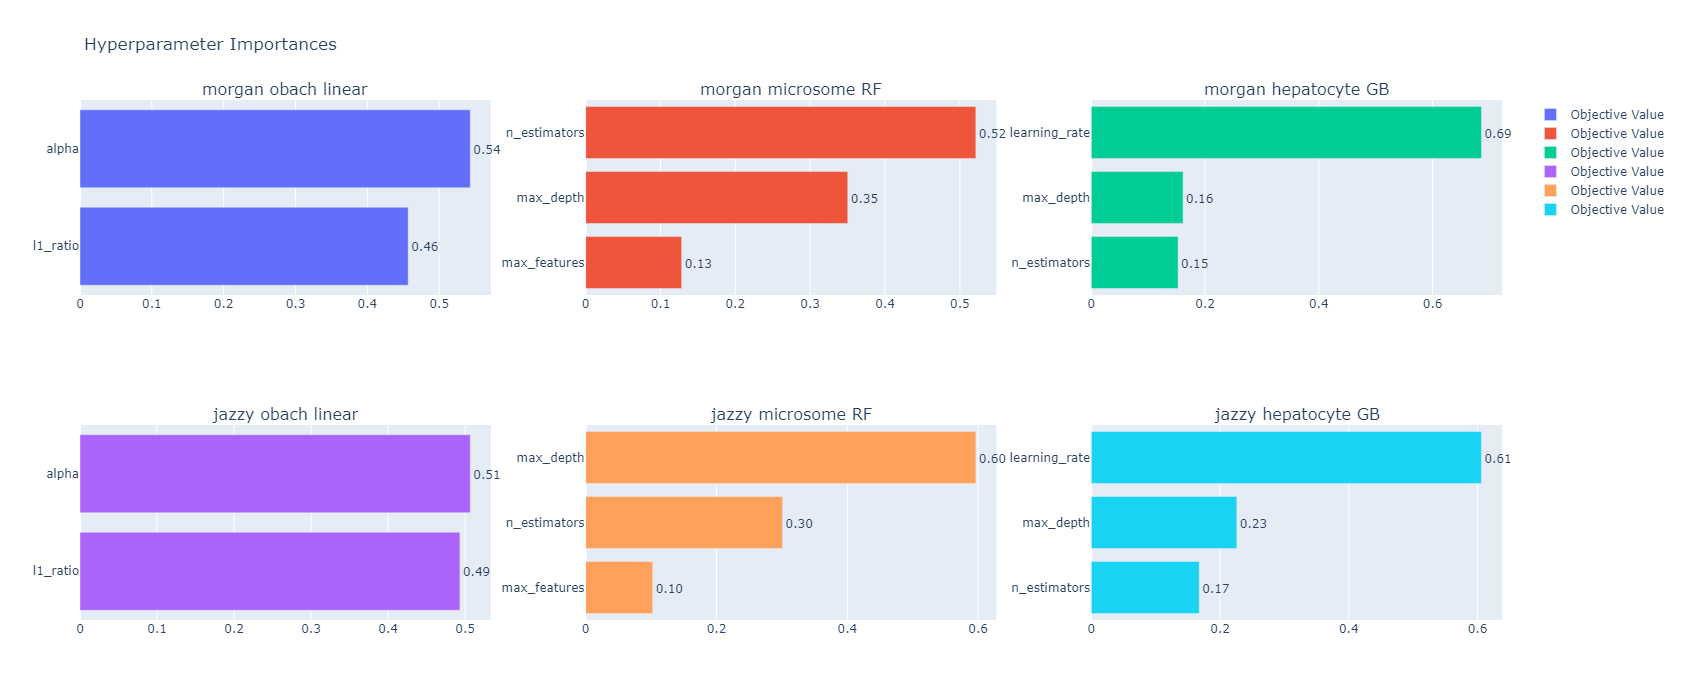

In [132]:
rows = 2
cols = 3
height = 700
fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add each figure to the subplot
for i in range(rows):
    for j in range(cols):
        # Extract the data from the Figure class and add it to the subplot
        trace = plots[i * cols + j]['data'][0]
        fig.add_trace(trace, row=i + 1, col=j + 1)   

# Update layout and show the plot
fig.update_layout(title_text="Hyperparameter Importances", height=height)
fig.show()

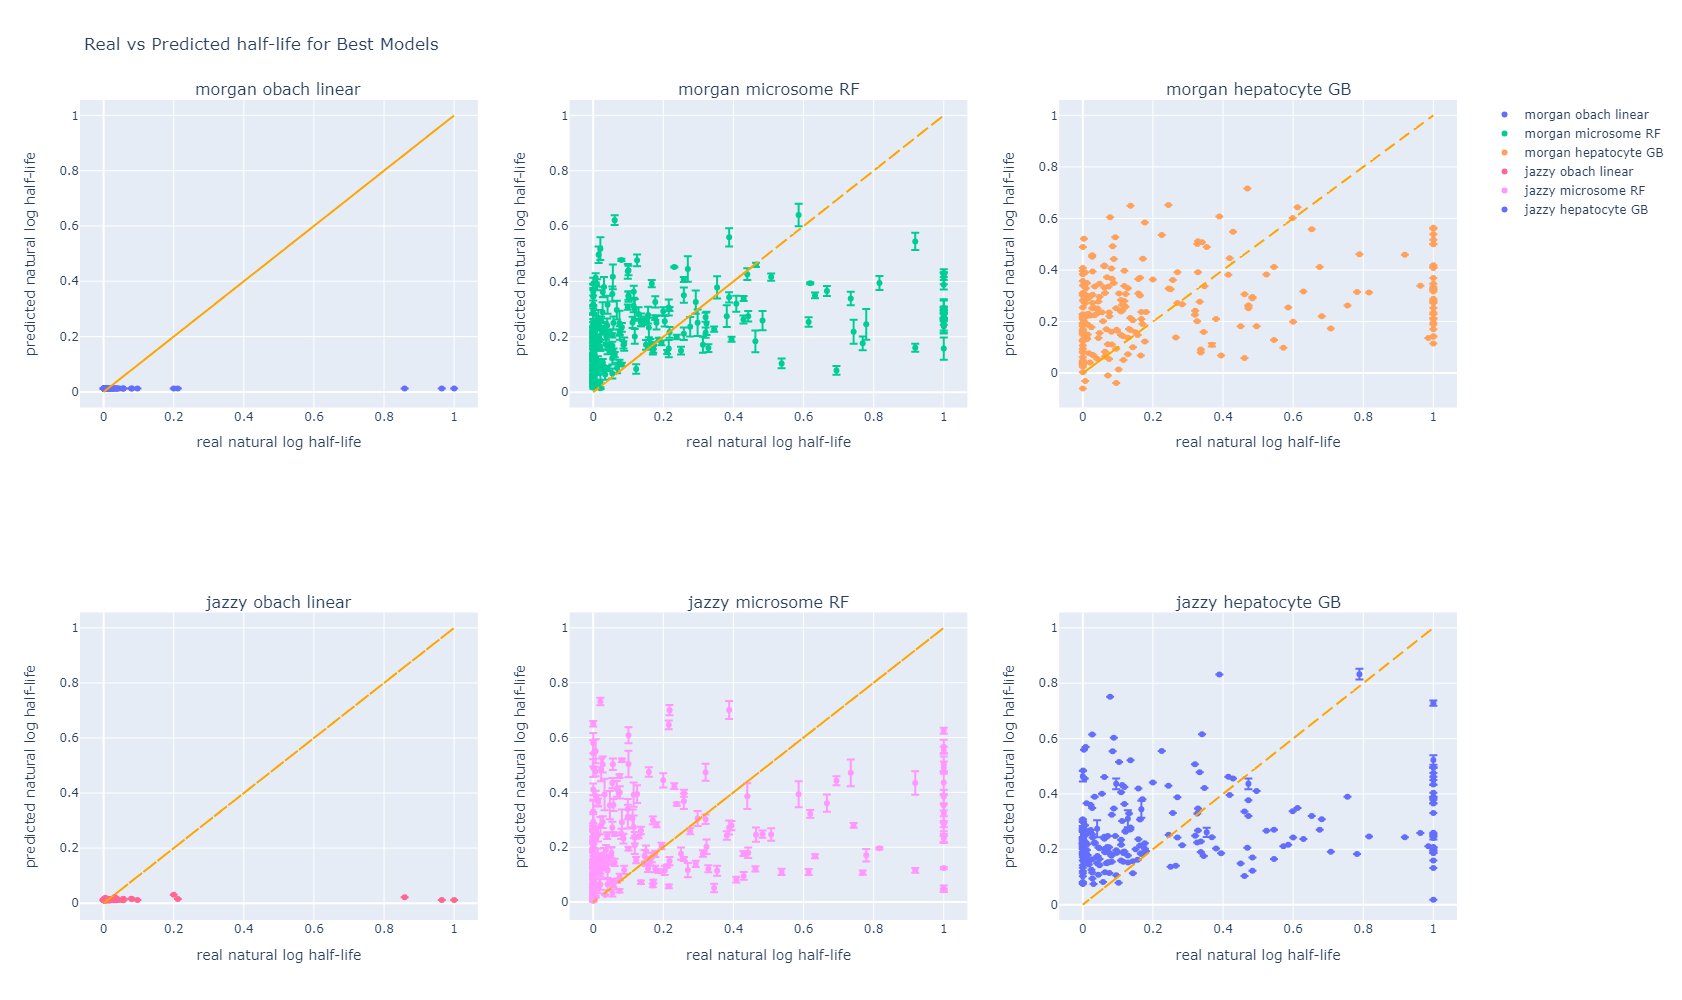

In [133]:
rows = 2
cols = 3
height = 700
fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=titles)
plot_counter = 0
y_predicted["morgan"] = {}
y_predicted["jazzy"] = {}

for title in titles:
    parts = title.split()
    _type = parts[0]
    benchmark = parts[1]
    best_model = parts[2]
    
    df = pd.read_csv(f"project_resources/optuna/{benchmark}/{_type}/{best_model}.csv")
    best_trial_num = best_trials[_type][benchmark][best_model]
    best_trial_results = df.loc[df['Trial Number'] == best_trial_num].to_dict()

    plot_x = halflives[_type][benchmark]["test"]
    plot_y = np.fromstring(best_trial_results["Predictions"][best_trial_num][1:-1], sep=', ')
    std = np.fromstring(best_trial_results["Std"][best_trial_num][1:-1], sep=',')
    
    y_predicted[_type][benchmark] = {}
    y_predicted[_type][benchmark][best_model] = plot_y

    scatter_trace = go.Scatter(
        x=plot_x,
        y=plot_y,
        mode='markers',
        error_y=dict(type='data', array=std, visible=True),
        name=f'{_type} {benchmark} {best_model}'
    )

    # Add the diagonal line
    diagonal_trace = go.Scatter(
        x=plot_x,
        y=plot_x,
        mode='lines',
        line=dict(color='orange', dash='dash'),
        showlegend=False
    )

    # Add the traces to the subplot
    fig.add_trace(scatter_trace, row=plot_counter // 3 + 1, col=plot_counter % 3 + 1)
    fig.add_trace(diagonal_trace, row=plot_counter // 3 + 1, col=plot_counter % 3 + 1)

    # Customize the subplot
    fig.update_xaxes(title_text='real natural log half-life', row=plot_counter // 3 + 1, col=plot_counter % 3 + 1)
    fig.update_yaxes(title_text='predicted natural log half-life', row=plot_counter // 3 + 1, col=plot_counter % 3 + 1)

    plot_counter += 1
            
fig.update_layout(height=1000, title_text="Real vs Predicted half-life for Best Models")
fig.show()

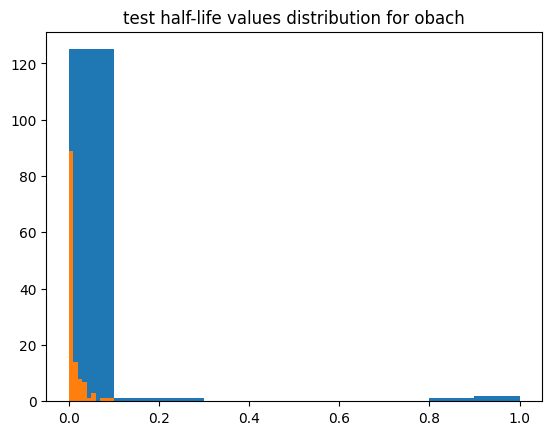

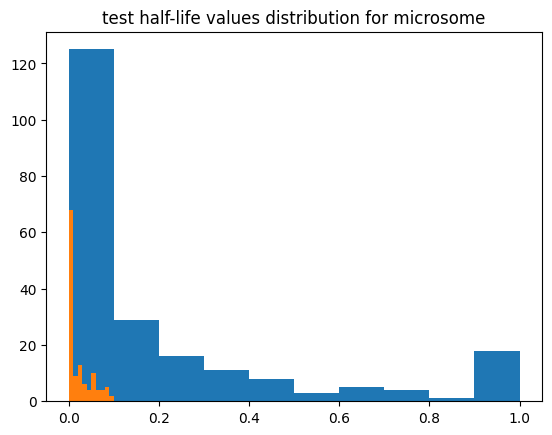

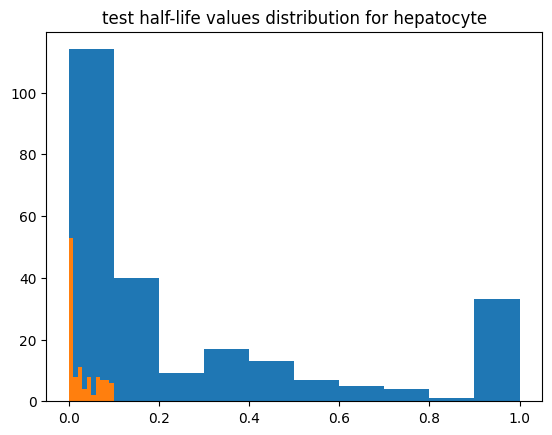

In [134]:
for benchmark in tdc_benchmarks:
    plt.hist(halflives[_type][benchmark]["test"])
    plt.hist(halflives[_type][benchmark]["test"], range=(0, 0.1))
    plt.title(f"test half-life values distribution for {benchmark}")
    plt.show()

In [135]:
for title in titles:
    parts = title.split()
    _type = parts[0]
    benchmark = parts[1]
    best_model = parts[2]
    
    print(_type, benchmark, best_model)
    print(spearmanr(halflives[_type][benchmark]["test"], y_predicted[_type][benchmark][best_model]))
    print("R^2 score:", r2_score(halflives[_type][benchmark]["test"], y_predicted[_type][benchmark][best_model]))
    print("\n")

morgan obach linear
SpearmanrResult(correlation=nan, pvalue=nan)
R^2 score: -0.025174111951574707


morgan microsome RF
SpearmanrResult(correlation=0.5270957275123982, pvalue=3.9540350396926115e-17)
R^2 score: 0.13400770910869575


morgan hepatocyte GB
SpearmanrResult(correlation=0.32685776373266023, pvalue=1.8599081300888183e-07)
R^2 score: 0.053232570330280726


jazzy obach linear
SpearmanrResult(correlation=0.1472753467744239, pvalue=0.09450258979196215)
R^2 score: -0.01818417840199915


jazzy microsome RF
SpearmanrResult(correlation=0.36254430144896327, pvalue=3.089791311681728e-08)
R^2 score: -0.02564863883602375


jazzy hepatocyte GB
SpearmanrResult(correlation=0.2642124699662657, pvalue=3.022020490223918e-05)
R^2 score: 0.024537017388275628




In [136]:
# create two dataframes for each dataset; one for real the other for predicted test, compute pd.DataFrame.rank for each of them and return rank(real)/rank(predicted)
ranks["morgan"] = {}
ranks["jazzy"] = {}
for title in titles:
    parts = title.split()
    _type = parts[0]
    benchmark = parts[1]
    best_model = parts[2]
    real_thalf = halflives[_type][benchmark]["test"]
    predicted_thalf = y_predicted[_type][benchmark][best_model]
    real_df = pd.DataFrame(real_thalf, columns=["real thalf"])
    predicted_df = pd.DataFrame(predicted_thalf, columns=["predicted thalf"])
    
    real_rank = np.array(real_df.rank()["real thalf"])
    predicted_rank = np.array(predicted_df.rank()["predicted thalf"])
    ranks[_type][benchmark] = {}
    ranks[_type][benchmark][best_model] = real_rank / predicted_rank

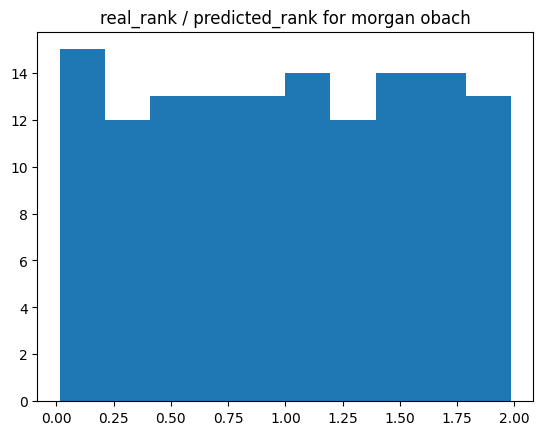

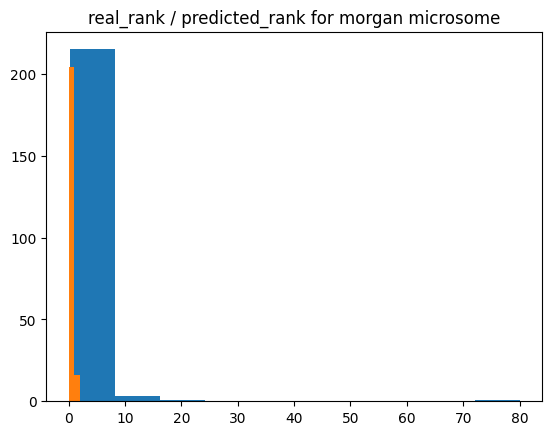

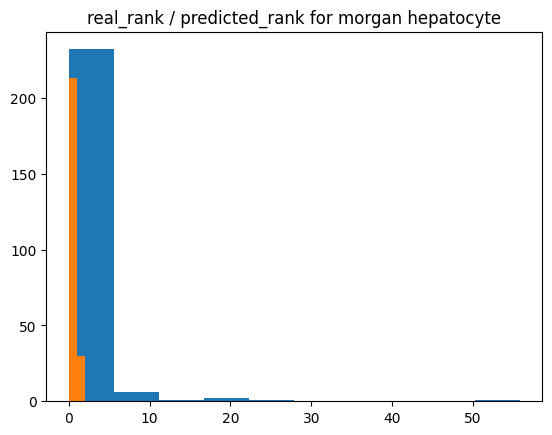

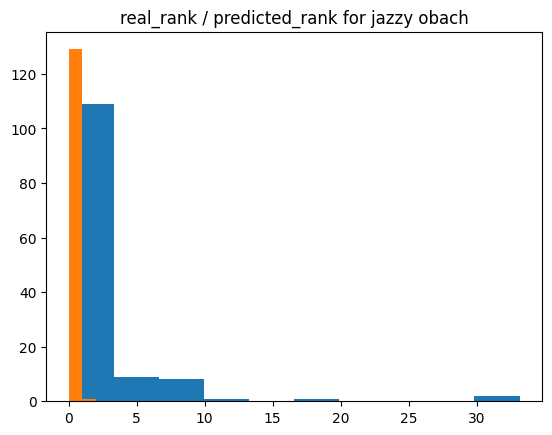

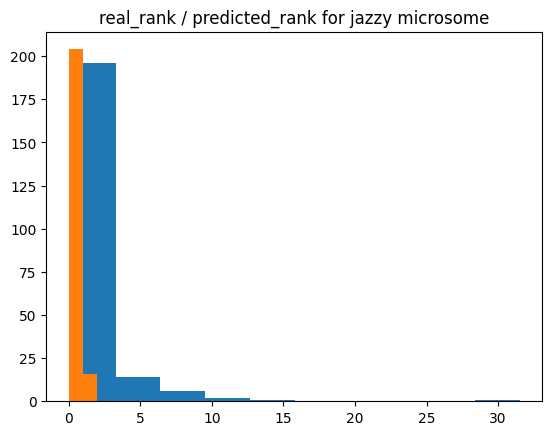

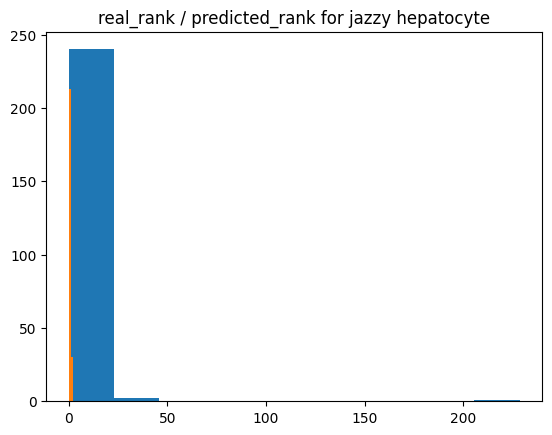

In [137]:
for title in titles:
    parts = title.split()
    _type = parts[0]
    benchmark = parts[1]
    best_model = parts[2]
    
    plt.hist(ranks[_type][benchmark][best_model])
    if _type != "morgan" or benchmark != "obach":
        plt.hist(halflives[_type][benchmark]["test"], range=(0, 10))
    plt.title(f"real_rank / predicted_rank for {_type} {benchmark}")
    plt.show()

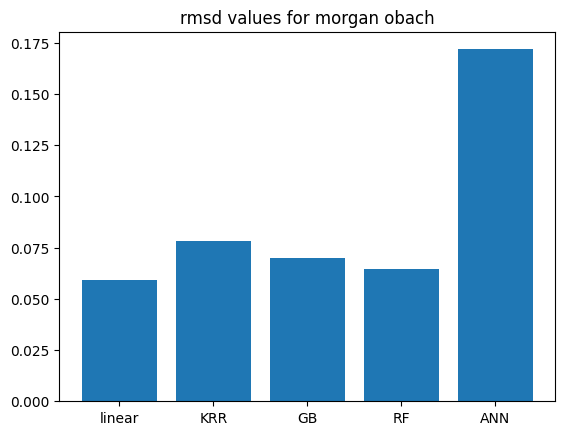

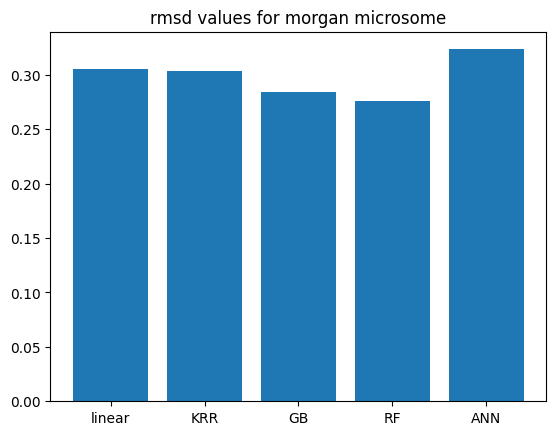

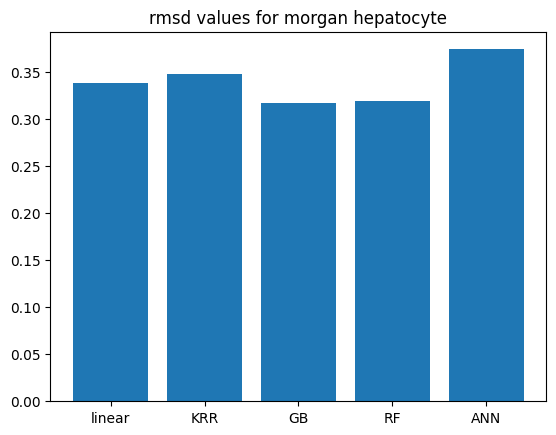

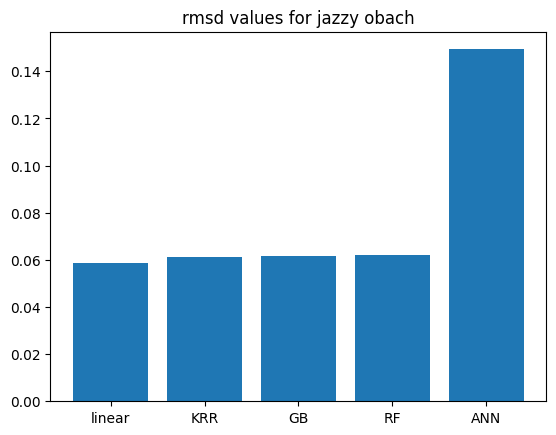

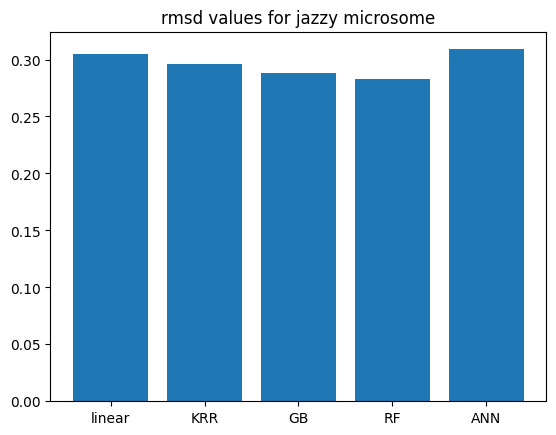

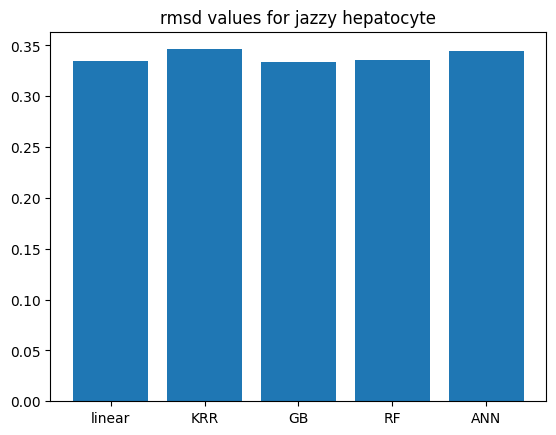

In [138]:
for _type in feature_types:
    for benchmark in tdc_benchmarks:
        dataset_rmsds = []
        for model_id in model_identifiers:
            dataset_rmsds.append(rmsds[_type][benchmark][model_id])
        plt.bar(model_identifiers, dataset_rmsds)
        plt.title(f"rmsd values for {_type} {benchmark}")
        plt.show()